# PINN with modified foward propagation

Modified foward propagation for making sure to respect the initial conditions

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def ODE_1(t, y): # Exponential decay
    # y: R^1, lambda: 0.1
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return -0.1 * y

ODE_1_y0 = torch.tensor([2.0]).to(device)

def ODE_2(t, y): # Van der Pol Oscillator
    # y: R^2, mu: 2
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    x = y[0]
    dy = y[1]
    # Parameters
    omega = 1.0
    zeta = 0.5
    
    dydt = torch.stack([dy, -omega**2 * x - 2 * zeta * omega * dy]).to(device)
    return dydt

ODE_2_y0 = torch.tensor([2.0, 0.0]).to(device)

In [3]:
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def he_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def uniform_init(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=-0.1, b=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def normal_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [4]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_layers,
        num_neurons,
        num_outputs,
        y_0,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            y_0 (torch.Tensor): the initial condition for the ODE
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        
        self.y_0 = y_0.to(device)

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, num_outputs))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        t = x.to(device)
        model_out = self.network(t.reshape(-1, 1)).squeeze()
        y = self.y_0 + (1 - torch.exp(-t)).view(-1, 1) * model_out
        return y

In [5]:
model = LinearNN(1, 4, 64, 2, ODE_2_y0).to(device)

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)

In [6]:
ODE_batch = vmap(ODE_2, in_dims=0)

In [7]:
def loss_fn(t: torch.Tensor):
    # INTERIOR LOSS
    # NN grads
    y = model(t)
    jacobians = batched_jacobian_fn(t)
    dydt = jacobians.squeeze(-1)
    
    # ODE actual grads
    ode_grads = ODE_batch(t, y)
    
    loss = nn.MSELoss()
    return loss(dydt, ode_grads)
    

In [8]:
batch_size = 2048  # number of colocation points to sample in the domain
num_iter = 1000  # maximum number of iterations
learning_rate = 1e-3  # learning rate
weight_decay = 1e-5  # weight decay
T = 10  # final time

optimzier = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


for i in range(num_iter):
    t = (torch.rand(batch_size) * T).to(device) 
    t.to(device)
    t.requires_grad_(True)
    
    loss = loss_fn(t)
    loss.backward()
    optimzier.step()
    optimzier.zero_grad()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

/home/vedo/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2048, 2])) that is different to the input size (torch.Size([2048, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0, Loss: 2.144108295440674
Iteration 10, Loss: 0.31747347116470337
Iteration 20, Loss: 0.18927140533924103
Iteration 30, Loss: 0.1769639551639557
Iteration 40, Loss: 0.1705317497253418
Iteration 50, Loss: 0.1525237262248993
Iteration 60, Loss: 0.16838034987449646
Iteration 70, Loss: 0.13739639520645142
Iteration 80, Loss: 0.1661221832036972
Iteration 90, Loss: 0.15266107022762299
Iteration 100, Loss: 0.13187605142593384
Iteration 110, Loss: 0.14620009064674377
Iteration 120, Loss: 0.14484119415283203
Iteration 130, Loss: 0.1394459307193756
Iteration 140, Loss: 0.15432977676391602
Iteration 150, Loss: 0.15031418204307556
Iteration 160, Loss: 0.14822451770305634
Iteration 170, Loss: 0.1527685970067978
Iteration 180, Loss: 0.12395092844963074
Iteration 190, Loss: 0.13274389505386353
Iteration 200, Loss: 0.1532345414161682
Iteration 210, Loss: 0.14742815494537354
Iteration 220, Loss: 0.13761921226978302
Iteration 230, Loss: 0.15542015433311462
Iteration 240, Loss: 0.1459278464317

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp

In [11]:
def ODE_1_np(t, y):
    dydt = ODE_1(t, y)
    return dydt.cpu().numpy()


def ODE_2_np(t,y):
    dydt = ODE_2(t, y)
    return dydt.cpu().numpy()

In [12]:
sol = solve_ivp(ODE_2_np, (0, T), ODE_2_y0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

In [13]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()


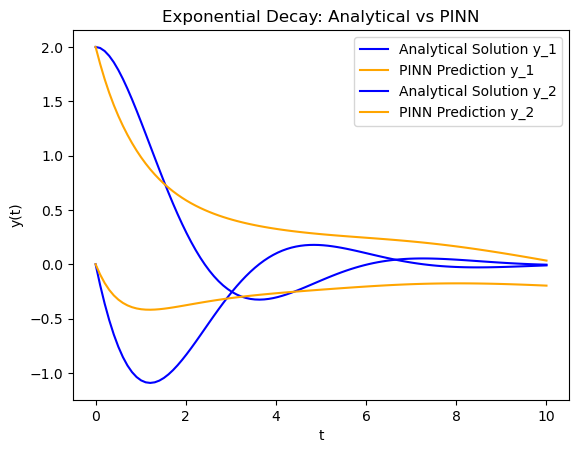

In [14]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()